## `evolvepy` Tuning Analysis
Objective: Load the raw JSON data generated by `02_run_tuning.py`, process and normalize it, and generate comparison plots to select the single "winning" strategy for the final showcase.

In [1]:
# Import standard libraries
import numpy as np
import pandas as pd
import glob
import json
import sys
import os
from typing import List, Dict, Any

# Path Setup
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import our custom plotting functions from utils
from utils.plotting import plot_strategy_comparison, plot_tuning_convergence

In [2]:
# Define paths to our data files

# Directory where '02_run_tuning.py' saved its results
TUNING_RESULTS_DIR = "../experiments/tuning_results" 
# The baseline file generated by '01_generate_baseline.py'
BASELINE_FILE = "../data/baseline_hc.json" 
# Where to save the plots generated by this notebook
PLOT_OUTPUT_DIR = "../experiments"

In [3]:
# Load the baseline file and all raw strategy results into memory.

# Load baseline (our "ground truth")
try:
    with open(BASELINE_FILE, 'r') as f:
        baseline_data = json.load(f)
    print(f"Loaded baseline data from {BASELINE_FILE}")
except FileNotFoundError:
    print(f"ERROR: Baseline file not found at {BASELINE_FILE}")
    raise

# Find all strategy result files
result_files = glob.glob(os.path.join(TUNING_RESULTS_DIR, "*.json"))
if not result_files:
    print(f"ERROR: No result files found in {TUNING_RESULTS_DIR}")
    raise

print(f"Found {len(result_files)} strategy result files.")

# This list will hold all our raw data
all_run_data = []

# Loop through each strategy's JSON file
for file_path in result_files:
    strategy_name = os.path.basename(file_path).replace(".json", "")
    
    with open(file_path, 'r') as f:
        strategy_data = json.load(f) # This is a dict: {problem_name: [run_histories]}
        
    # De-nest the data
    for problem_name, run_histories in strategy_data.items():
        # run_histories is a list of N full 'history' objects
        for run_index, history in enumerate(run_histories):
            
            # This is one full run. Let's store its metadata.
            # We also store the *full history* for convergence plotting
            all_run_data.append({
                "strategy_name": strategy_name,
                "problem_name": problem_name,
                "run_index": run_index,
                "full_history": history["best_fitness"] # We only need the best_fitness list
            })

# Convert our list of dictionaries into a powerful Pandas DataFrame
df_raw = pd.DataFrame(all_run_data)

print(f"\nSuccessfully loaded {len(df_raw)} total runs into DataFrame.")
df_raw.head()

Loaded baseline data from ../data/baseline_hc.json
Found 64 strategy result files.

Successfully loaded 960 total runs into DataFrame.


,strategy_name,problem_name,run_index,full_history
0,Shape_Deep_Tourn_k5_StdRep_CX_0.5_Invert_0.8_C...,problem_g_500.npy,0,"[-124230.4088978961, -121151.33873702274, -120..."
1,Shape_Deep_Tourn_k5_StdRep_CX_0.5_Invert_0.8_C...,problem_g_500.npy,1,"[-125645.75060069488, -124711.90128877985, -12..."
2,Shape_Deep_Tourn_k5_StdRep_CX_0.5_Invert_0.8_C...,problem_g_500.npy,2,"[-124009.47246406568, -123995.56554255333, -12..."
3,Shape_Deep_Tourn_k5_StdRep_CX_0.5_Invert_0.8_C...,problem_g_100.npy,0,"[-23318.07877508712, -23259.36061806641, -2292..."
4,Shape_Deep_Tourn_k5_StdRep_CX_0.5_Invert_0.8_C...,problem_g_100.npy,1,"[-24266.25969344429, -24266.25969344429, -2380..."


In [4]:
# We normalize all results against the
# baseline to make them comparable.

# Get Final Fitness
# Extract the *last* fitness value from the history list for each run
df_raw['final_fitness'] = df_raw['full_history'].apply(lambda history_list: history_list[-1])

# Map Baseline Fitness
# Add the baseline fitness to each row based on its problem_name
df_raw['baseline_fitness'] = df_raw['problem_name'].map(baseline_data)

# Calculate Normalized Improvement
# This is our key metric: (% Improvement over Baseline)
# (ea_fitness - baseline_fitness) / abs(baseline_fitness) * 100
# Example: (-2950 - (-3000)) / abs(-3000) = 50 / 3000 = 1.67%
def calculate_improvement(row):
    ea_fit = row['final_fitness']
    baseline_fit = row['baseline_fitness']
    if baseline_fit is None or baseline_fit == 0:
        return None
    return (ea_fit - baseline_fit) / abs(baseline_fit) * 100

df_raw['improvement_pct'] = df_raw.apply(calculate_improvement, axis=1)

# This new DataFrame contains *only* the final, aggregated results.
df_final_results = df_raw.dropna(subset=['improvement_pct'])

print("Data normalization complete.")
print("\nFinal Results (Aggregated):")
df_final_results.head()

Data normalization complete.

Final Results (Aggregated):


,strategy_name,problem_name,run_index,full_history,final_fitness,baseline_fitness,improvement_pct
0,Shape_Deep_Tourn_k5_StdRep_CX_0.5_Invert_0.8_C...,problem_g_500.npy,0,"[-124230.4088978961, -121151.33873702274, -120...",-67083.626042,-40104.876991,-67.270494
1,Shape_Deep_Tourn_k5_StdRep_CX_0.5_Invert_0.8_C...,problem_g_500.npy,1,"[-125645.75060069488, -124711.90128877985, -12...",-65454.032674,-40104.876991,-63.207165
2,Shape_Deep_Tourn_k5_StdRep_CX_0.5_Invert_0.8_C...,problem_g_500.npy,2,"[-124009.47246406568, -123995.56554255333, -12...",-63847.687130,-40104.876991,-59.201803
3,Shape_Deep_Tourn_k5_StdRep_CX_0.5_Invert_0.8_C...,problem_g_100.npy,0,"[-23318.07877508712, -23259.36061806641, -2292...",-11099.955396,-5945.378406,-86.698888
4,Shape_Deep_Tourn_k5_StdRep_CX_0.5_Invert_0.8_C...,problem_g_100.npy,1,"[-24266.25969344429, -24266.25969344429, -2380...",-11717.269799,-5945.378406,-97.081985


Generating Final Quality Box Plot...


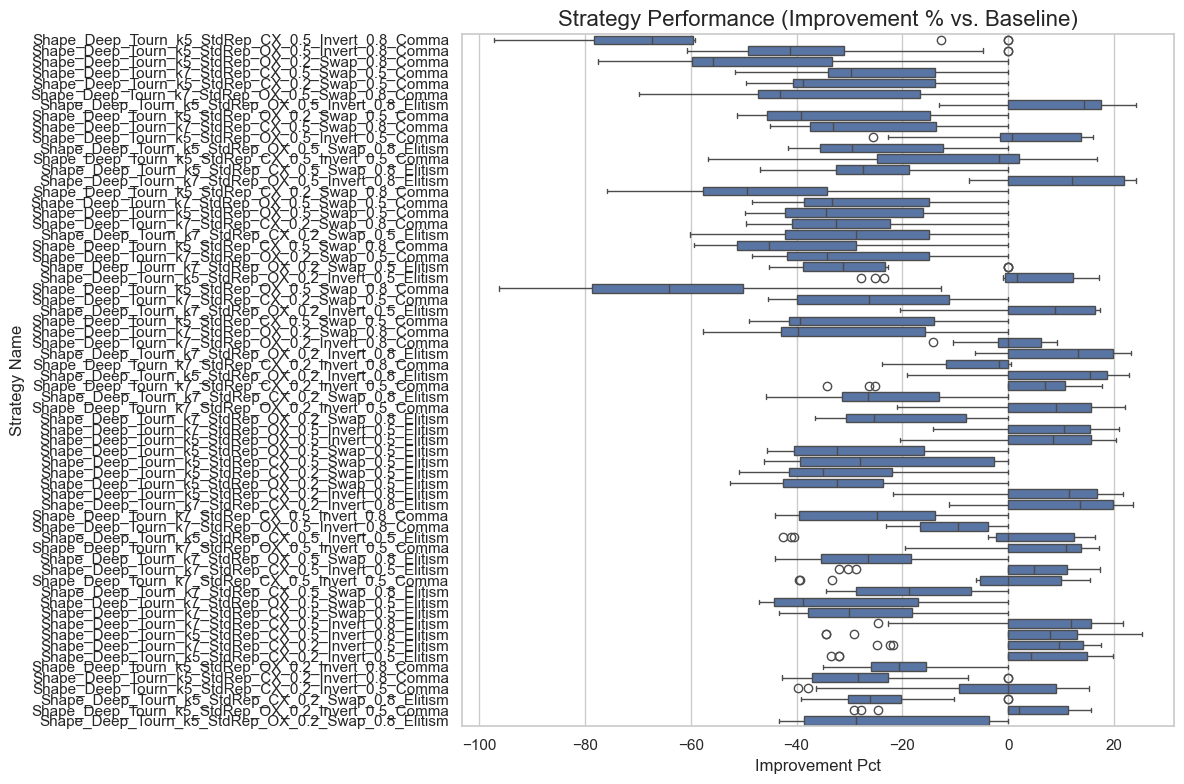

In [5]:
print("Generating Final Quality Box Plot...")

# Use our imported plotting function
plot_strategy_comparison(
    data=df_final_results,
    x="improvement_pct",
    y="strategy_name",
    title="Strategy Performance (Improvement % vs. Baseline)",
    save_path=os.path.join(PLOT_OUTPUT_DIR, "01_tuning_quality_boxplot.png"),
    show=True
)

Generating Convergence Speed Line Plot...
Loading and processing all tuning data...
Finding the top 5 performing strategies...
Top strategies found: ['Shape_Deep_Tourn_k7_StdRep_OX_0.5_Invert_0.8_Elitism', 'Shape_Deep_Tourn_k7_StdRep_OX_0.2_Invert_0.8_Elitism', 'Shape_Deep_Tourn_k7_StdRep_CX_0.2_Invert_0.8_Elitism', 'Shape_Deep_Tourn_k5_StdRep_OX_0.5_Invert_0.8_Elitism', 'Shape_Deep_Tourn_k5_StdRep_OX_0.2_Invert_0.8_Elitism']
Generating convergence plot...


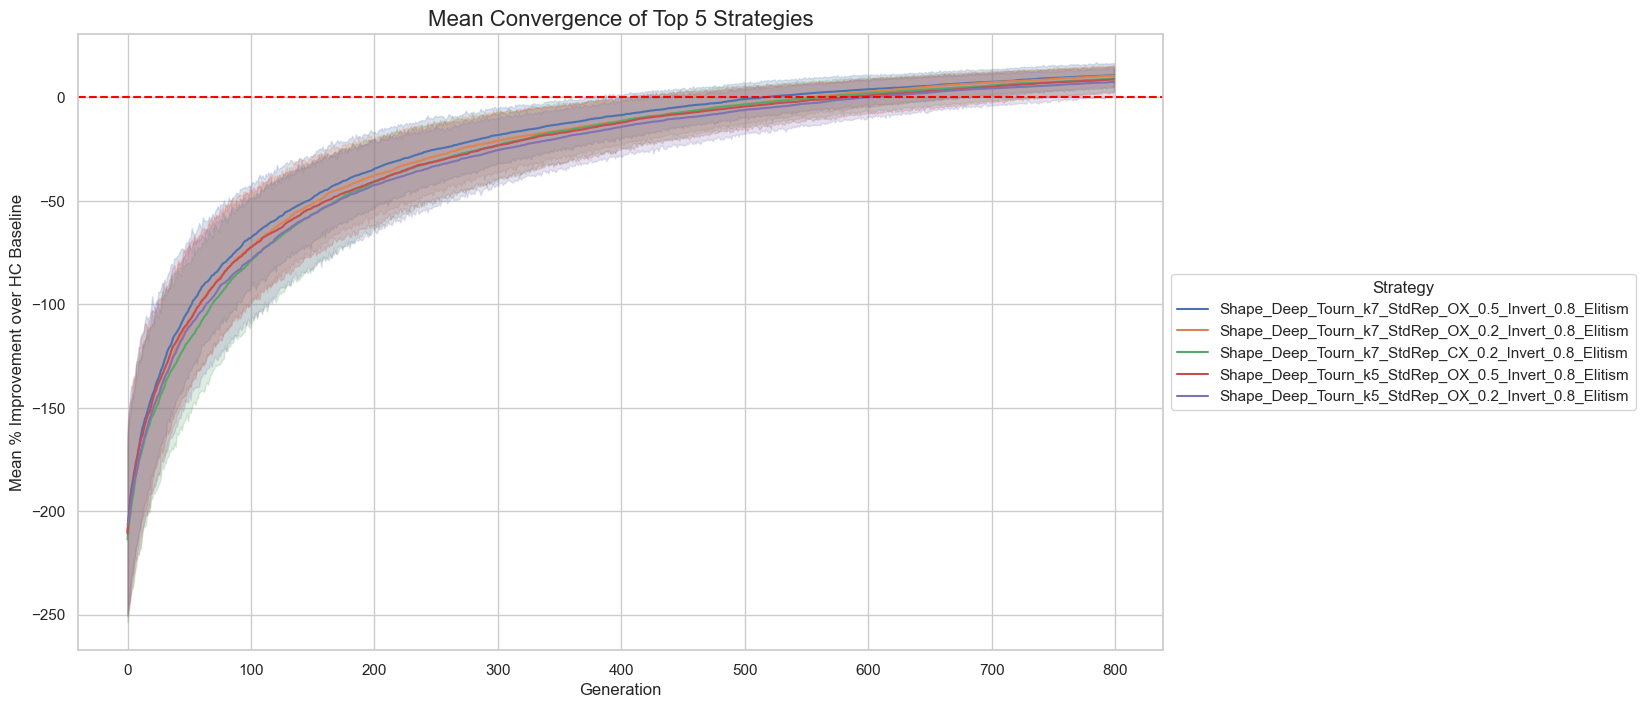

In [6]:
# print("Preparing data for convergence plot...")

# explode the 'full_history' lists into individual rows.
# gen_data = []
# for _, row in df_raw.iterrows():
#     for gen, fitness in enumerate(row['full_history']):
#         gen_data.append({
#             "strategy_name": row['strategy_name'],
#             "problem_name": row['problem_name'],
#             "run_index": row['run_index'],
#             "generation": gen,
#             "fitness": fitness
#         })
# df_gen = pd.DataFrame(gen_data)

# Now, normalize this generation-by-generation data
# df_gen['baseline_fitness'] = df_gen['problem_name'].map(baseline_data)
# df_gen['gen_improvement_pct'] = df_gen.apply(
#     lambda row: (row['fitness'] - row['baseline_fitness']) / abs(row['baseline_fitness']) * 100
#     if row['baseline_fitness'] is not None and row['baseline_fitness'] != 0 else None,
#     axis=1
# ).dropna()

# print(f"Generated {len(df_gen)} rows for convergence plotting.")

# Plot the convergence curves
print("Generating Convergence Speed Line Plot...")

# Use our imported plotting function
# Seaborn's lineplot will automatically average all runs
# for each strategy and plot the mean + confidence interval.

plot_tuning_convergence(
    results_dir=TUNING_RESULTS_DIR,
    baseline_file_path=BASELINE_FILE,
    top_k=5,
    save_path=os.path.join(PLOT_OUTPUT_DIR, "01_tuning_convergence_plot.png"),
    show=True
)